In [2]:
from pyscf import gto, scf, lo, tools, fci, ao2mo, mcscf, df

from openfermion import MolecularData

from openfermionpyscf import run_pyscf, compute_integrals
from openfermionpyscf import prepare_pyscf_molecule
import module as md
from openfermion.transforms import get_fermion_operator, jordan_wigner,\
    bravyi_kitaev, bravyi_kitaev_fast, get_interaction_operator, JW1norm
# from tqdm import tqdm
import numpy as np

In [24]:
# Set molecule parameters.
basis = ['sto-3g', 'cc-pvdz'][1]
multiplicity = 1
# Set calculation parameters.
consider_cas = 1
run_scf = 1
run_mp2 = 0
run_cisd = 0
run_ccsd = 0
run_fci = 0
run_casci = 0
n_orbitals = 10
n_electrons = 10
verbose = 1
localize = 0
visualize = 0
localizemethod = ['Boys','Pipek-Mezey','ibo','ER'][1]
localize_virt = 0 # Choose whether you want to localize the virtual MO's
if consider_cas:
    localize_cas = 1 # Localize only in the CAS
    only_cas = 1 # Store only the CAS integrals in the molecule object
else:
    localize_cas = 0
    only_cas = 0 

localize_sep = 0
do_svd = 0
also_h1e = 0
do_cholesky = 0
Orth_AO = 0
# delete_input = True
# delete_output = True
save_tohdf5 = 0
max_memory = 8000
H_chain = 0
H_ring = 0
    
fname = ['xyz_files/H2nosym.txt','xyz_files/H2COnosym.txt','xyz_files/H10.txt',\
         'xyz_files/C2.txt', 'xyz_files/LiH.txt', 'xyz_files/HLiO.txt', \
         'xyz_files/H2Onosym.txt', 'xyz_files/H14.txt', \
         'xyz_files/hnch2_s0min_dzp.txt', 'xyz_files/hnc3h6_s0min_dzp.txt',\
         'xyz_files/hnc5h10_s0min_dzp.txt', 'xyz_files/hnc7h14_s0min_dzp.txt',\
         'xyz_files/benzene.txt','xyz_files/PCy3.txt','xyz_files/PCy3Cl2Ru.txt'][8]
geometry = md.xyz_to_geom(fname)
if run_fci:
    description = fname.replace('xyz_files/','').replace('.txt','') +\
        str(basis) + 'FCI'
elif run_casci or consider_cas:
    description = fname.replace('xyz_files/','').replace('.txt','') + str(basis)\
        + 'ne' + str(n_electrons) + 'no' + str(n_orbitals)
else:
    description = fname.replace('xyz_files/','').replace('.txt','') + str(basis)
if do_cholesky:
    description += 'chol'

#description += localizemethod
nao = md.count_ao(geometry, basis)
nelec = md.count_elec(geometry,basis)
ndocc = nelec // 2
print('Molecule we are considering is:',geometry)
print('Number of AOs:', nao)
print('Number of electrons:', nelec)
print('\n')


threshold = 1e-10

print('Considering', n_electrons, 'electrons in', n_orbitals, 'orbitals')

localize = 0
localize_virt = 0 

molecule = MolecularData(
    geometry, basis, multiplicity,
    description=description)

mol = prepare_pyscf_molecule(molecule)

myhf = scf.RHF(mol)
myhf.run()

Molecule we are considering is: [('N', (-0.42427069, 0.43533599, 0.0)), ('C', (0.16299131, -0.68547816, 0.0)), ('H', (-0.43843192, -1.59302707, 0.0)), ('H', (1.24744035, -0.82080847, 0.0)), ('H', (0.2524034, 1.2023508, 0.0))]
Number of AOs: 43
Number of electrons: 16


Considering 10 electrons in 10 orbitals
converged SCF energy = -94.0392279960231


In [7]:
C_nonloc = myhf.mo_coeff
S = myhf.get_ovlp()
S_eigval, S_eigvec = np.linalg.eigh(S)
S_sqrt_inv = S_eigvec @ np.diag((S_eigval)**(-1./2.)) @ np.linalg.inv(S_eigvec)
S_sqrt = S_eigvec @ np.diag((S_eigval)**(1./2.)) @ np.linalg.inv(S_eigvec)

In [15]:
Proj = np.zeros((nao,nao))
for p in range(nao):
    for r in range(nao):
        Proj[p,r] = np.abs((C_nonloc.T @ S_sqrt)[p,r]) ** 2
    

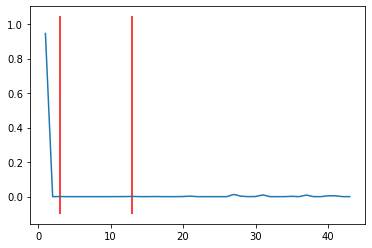

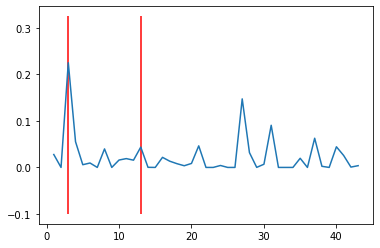

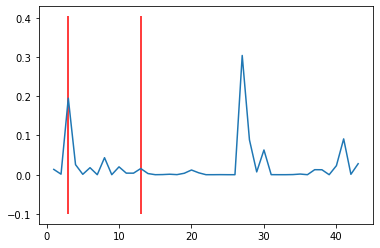

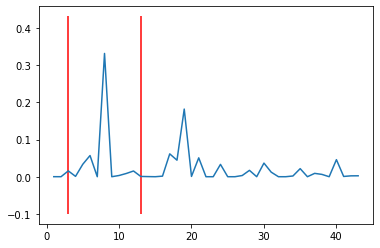

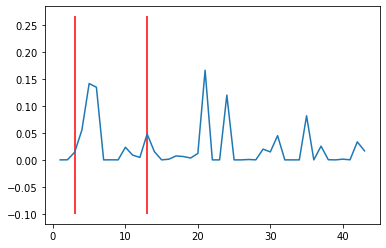

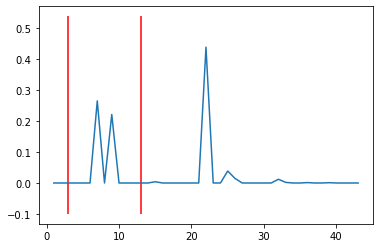

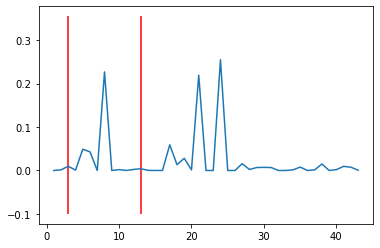

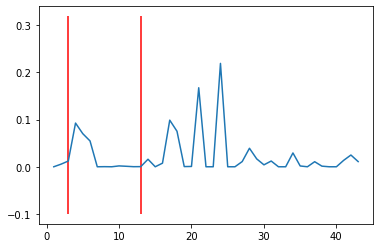

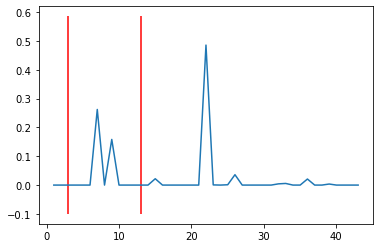

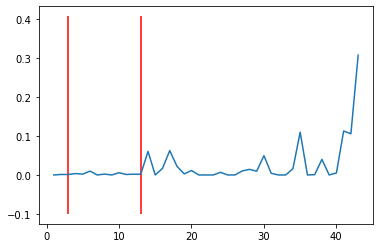

In [36]:
import matplotlib.pyplot as plt

x = np.array(np.arange(1,nao+1))

for r in range(10):
    y_0 = []
    for p in range(nao):
        y_0.append(Proj[p,r])
    plt.figure()
    plt.vlines([ndocc-(n_orbitals//2),ndocc + (n_orbitals//2)],min(y_0)-0.1, max(y_0)+0.1, colors='red')
    plt.plot(x,y_0)
plt.show()

In [62]:
sum_proj = np.zeros((nao,))
for r in range(nao):
    sum_proj[r] = np.sum(Proj[ndocc-(n_orbitals//2):ndocc + (n_orbitals//2),r])
print(sum_proj)

[0.00209725 0.20463418 0.13134783 0.45068256 0.41578306 0.48690971
 0.32796404 0.22107321 0.42046105 0.02854882 0.01610639 0.00461507
 0.00470613 0.01449133 0.00197017 0.22976189 0.2145312  0.41934387
 0.34724213 0.42644861 0.30081337 0.56558254 0.49098181 0.12964132
 0.04723285 0.04073421 0.01246339 0.07873452 0.31438024 0.8103816
 0.08647615 0.12201231 0.03024695 0.31022591 0.80490632 0.14112351
 0.06974959 0.03127784 0.26082902 0.79337547 0.07549094 0.08145638
 0.03316528]


In [66]:
active_OAO = sum_proj.argsort()[::-1][:8]

In [67]:
active_OAO

array([29, 34, 39, 21, 22,  5,  3, 19])

In [68]:
sum_proj[active_OAO]

array([0.8103816 , 0.80490632, 0.79337547, 0.56558254, 0.49098181,
       0.48690971, 0.45068256, 0.42644861])